In [1]:
import glob
import re
import pickle

import numpy as np
import pandas as pd
from isoweek import Week
from pandas_summary import DataFrameSummary
from keras.models import model_from_yaml
from utils import *
from keras.callbacks import TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20

%matplotlib inline

Using TensorFlow backend.
/usr/lib64/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Utility

In [90]:
## global config
# cat_vars = ['air_genre_name', 'air_area_name', 'hpg_genre_name', 
#     'hpg_area_name', 'holiday_flg', 'dur_time_holiday_flg',
#     'visit_date_week', 'visit_date_dayofweek', 'visit_date_year', 
#     'visit_date_month', 'air_store_id', 'visit_date_dayofmonth']
# contin_vars = ['air_latitude', 'air_longitude', 'hpg_latitude', 'hpg_longitude',
#         'af_holiday_flg', 'be_holiday_flg', 'dur_holiday_flg', 'dur_prog_holiday_flg',
#         'min_visits', 'max_visits', 'mean_visits', 'std_visits']

cat_vars = [
    'air_genre_name', 
    'air_area_name', 
    'hpg_genre_name', 
    'holiday_flg',
    'visit_date_dayofweek', 
    'visit_date_year', 
    'visit_date_month', 
    'air_store_id', 
    'visit_date_dayofmonth'
]
contin_vars = [
    'air_latitude', 
    'air_longitude',
    'dur_time_holiday_flg',
    'min_visits', 
    'max_visits', 
    'mean_visits', 
    'std_visits'
]


def fillCateNan(data, cat_vars = cat_vars):
    for cate in cat_vars:
        if cate in data.columns:
            data[cate] = data[cate].fillna('UD')
    return data

def fillContinNan(data, contin_vars = contin_vars):
    for contin in contin_vars:
        if contin in data.columns:
            data[contin] = data[contin].fillna(0)
    return data

def get_info_from_date(data, dt_vars):
    "get_info_from_date"
    for dt_var in dt_vars:
        data[dt_var] = pd.to_datetime(data[dt_var])
        data["{}_week".format(dt_var)] = data[dt_var].dt.week
        data["{}_dayofweek".format(dt_var)] = data[dt_var].dt.dayofweek
        data["{}_year".format(dt_var)] = data[dt_var].dt.year
        data["{}_month".format(dt_var)] = data[dt_var].dt.month
        data["{}_dayofmonth".format(dt_var)] = data[dt_var].dt.day
        
def data2fea(data, stores, hol):
    # Add [Store Info Features] into trn data
    data = pd.merge(data, stores, how='left')
    # Add [Time Series Features] into trn data
    get_info_from_date(data, ['visit_date'])

    #Add [Holiday Features] into trn data
    data = pd.merge(data, hol, how='left', left_on='visit_date', right_on='Date')
    data = fillCateNan(data)
    data = fillContinNan(data)

    data.drop(columns=['Date', 'day_of_week'], inplace=True)
    return data

def mat2fea(mat, cat_vars=cat_vars, contin_vars=contin_vars ):
    for v in contin_vars: mat.loc[mat[v].isnull(), v] = 0
    for v in cat_vars: mat.loc[mat[v].isnull(), v] = ""
    cat_maps = [(o, LabelEncoder()) for o in cat_vars]
    contin_maps = [([o], StandardScaler()) for o in contin_vars]


    cat_mapper = DataFrameMapper(cat_maps)
    cat_map_fit = cat_mapper.fit(mat)
    cat_cols = len(cat_map_fit.features)

    contin_mapper = DataFrameMapper(contin_maps)
    contin_map_fit = contin_mapper.fit(mat)
    contin_cols = len(contin_map_fit.features)
    def cat_preproc(dat):
        return cat_map_fit.transform(dat).astype(np.int64)

    def contin_preproc(dat):
        return contin_map_fit.transform(dat).astype(np.float)

    cat_map = cat_preproc(mat)
    contin_map = contin_preproc(mat)
    return cat_map, contin_map, cat_cols, contin_cols, cat_map_fit, mat.visitors

def genFeas(data, target):
    # Prepare store info
    data['as'] = data['as'].rename({'latitude': 'air_latitude', 'longitude': 'air_longitude'}, axis='columns')
    data['hs'] = data['hs'].rename({'latitude': 'hpg_latitude', 'longitude': 'hpg_longitude'}, axis='columns')
    stores = pd.merge(data['as'],  data['id'], how='left' )
    stores = pd.merge(stores,  data['hs'], how='left')
    # only use air_store_id
    stores = stores.drop(columns=['hpg_store_id'])

    # Prepare static of stores
    key = 'air_store_id'
    agg = data['tra'].groupby(key).agg([np.min, np.max, np.mean, np.std]).rename(
      columns={
        'amin': 'min_{}'.format('visits'),
        'amax': 'max_{}'.format('visits'),
        'mean': 'mean_{}'.format('visits'),
        'std': 'std_{}'.format('visits')
    })
    agg.reset_index(inplace=True)
    agg.columns = agg.columns.droplevel()
    agg = agg.reset_index()
    agg.rename(
        {
            '': key,
    }, axis='columns', inplace=True)

    #merge store statics into store info
    stores = pd.merge(stores, agg)

    #prepare holiday data
    hol = data["hol"]
    hol.rename(
        {
            'calendar_date': 'Date', 
    }, axis='columns', inplace=True)
    hol.Date = pd.to_datetime(hol.Date)
    fld = 'holiday_flg'
    hol = add_ts_elapsed(fld, ['af_', 'be_'], hol)  
    hol = add_ts_elapsed(fld, ['dur_'], hol)
#     str_date_hol = hol
    hol.Date = hol.Date.astype('str')
    
    
    # Add [Store Info Features] into trn data
    target = pd.merge(target, stores, how='left')
   
    # Add [Time Series Features] into trn data
    get_info_from_date(target, ['visit_date'])
    
    #Add [Holiday Features] into trn data
    target.visit_date = target.visit_date.astype('str')
    target = pd.merge(target, hol, how='left', left_on='visit_date', right_on='Date')
    target = fillCateNan(target)
    target = fillContinNan(target)
    target.drop(columns=['Date', 'day_of_week'], inplace=True)
    
    #Add Area staticts
    area_data = pd.merge(data['tra'], data['as'], how='left')
    area_data = area_data.drop(columns=['air_latitude', 'air_longitude', 'air_genre_name', 'air_store_id'] )
    # plt.hist(data_with_store.visitors[data_with_store.visitors>200])
    area_data = area_data.groupby('air_area_name').agg([np.median, np.mean, np.std]).rename(
          columns={
            'median': 'area_median_{}'.format('visits'),
            'mean': 'area_mean_{}'.format('visits'),
            'std': 'area_std_{}'.format('visits')
        })
    area_data.columns = area_data.columns.droplevel()
    area_data = area_data.reset_index()
    area_data.rename(
        {
            '': 'air_area_name',
    }, axis='columns', inplace=True)
    
    target = pd.merge(target, area_data, how='left')
    return target

def genModelFeas(data):
    sort_data = data.sort_values(by='visit_date', axis=0, ascending=True)
    sort_data = sort_data.reset_index()
    sort_data.drop(columns=['level_0'], inplace=True)
    sort_data.visit_date = sort_data.visit_date.apply(lambda x: x[:10])
    cat_map, contin_map, cat_cols, contin_cols, cat_map_fit, y = mat2fea(sort_data.drop(columns=['visit_date']))
    input_map = split_cols(cat_map) + [contin_map]
    feas = {
        'x_map': input_map,
        'y': y,
        'times': sort_data.visit_date,
        'contin_cols': contin_cols,
        'cat_map_fit': cat_map_fit,
        'sort_data': sort_data
    }
    return feas

## Preprocess

### Load Data

In [101]:
# load data
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
trn.drop

In [125]:
data_with_store = pd.merge(data['tra'], data['as'], how='left')
data_with_store = data_with_store.drop(columns=['air_latitude', 'air_longitude', 'air_genre_name', 'air_store_id'] )
# plt.hist(data_with_store.visitors[data_with_store.visitors>200])
data_with_store = data_with_store.groupby('air_area_name').agg([np.median, np.mean, np.std]).rename(
      columns={
        'median': 'area_median_{}'.format('visits'),
        'mean': 'area_mean_{}'.format('visits'),
        'std': 'area_std_{}'.format('visits')
    })
data_with_store.columns = data_with_store.columns.droplevel()
data_with_store = data_with_store.reset_index()
data_with_store.rename(
    {
        '': 'air_area_name',
}, axis='columns', inplace=True)
data_with_store
# display(area_info)

,air_area_name,area_median_visits,area_mean_visits,area_std_visits
0,Fukuoka-ken Fukuoka-shi Daimyō,17.0,20.667914,16.846033
1,Fukuoka-ken Fukuoka-shi Hakata Ekimae,18.0,21.149239,14.904164
2,Fukuoka-ken Fukuoka-shi Imaizumi,15.0,15.925000,9.101297
3,Fukuoka-ken Fukuoka-shi Momochi,11.0,20.365261,19.039513
4,Fukuoka-ken Fukuoka-shi Shiobaru,13.0,17.163837,15.372278
5,Fukuoka-ken Fukuoka-shi Takatori,25.0,29.761024,19.556400
6,Fukuoka-ken Fukuoka-shi Tenjin,20.0,22.933148,16.910495
7,Fukuoka-ken Fukuoka-shi Torikai,21.0,23.446680,16.205859
8,Fukuoka-ken Itoshima-shi Maebarunishi,13.0,18.560464,19.406101
9,Fukuoka-ken Kitakyūshū-shi Konyamachi,9.0,10.403960,5.942114


In [57]:
data = {
    'tra': pd.read_csv('{}/air_visit_data.csv'.format(data_dir)),
    # 'tes': pd.read_csv('{}/sample_submission.csv'.format(data_dir)),
    'as': pd.read_csv('{}/air_store_info.csv'.format(data_dir)),
    'hs': pd.read_csv('{}/hpg_store_info.csv'.format(data_dir)),
    'ar': pd.read_csv('{}/air_reserve.csv'.format(data_dir)),
    'hr': pd.read_csv('{}/hpg_reserve.csv'.format(data_dir)),
    'id': pd.read_csv('{}/store_id_relation.csv'.format(data_dir)),
    'hol': pd.read_csv('{}/date_info.csv'.format(data_dir))
}

### Generate features
#### Store, date, holiday

In [92]:
### DON'T re-run this cell
# stores, hol = genFeas(data, trn)
tt = genFeas(data, trn[:10])
# trn.to_csv('./result/trn_features_2.csv')

In [77]:
trn.tail(100)

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,air_latitude,air_longitude,hpg_genre_name,hpg_area_name,hpg_latitude,...,visit_date_dayofweek,visit_date_year,visit_date_month,visit_date_dayofmonth,holiday_flg,af_holiday_flg,be_holiday_flg,dur_time_holiday_flg,dur_holiday_flg,dur_prog_holiday_flg
252008,air_24e8414b9b07decb,2016-12-21,8,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,UD,NaN,NaN,...,2,2016,12,21,0,28,-2,0,0,0.000000
252009,air_24e8414b9b07decb,2016-12-22,8,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,UD,NaN,NaN,...,3,2016,12,22,0,29,-1,0,0,0.000000
252010,air_24e8414b9b07decb,2016-12-23,8,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,UD,NaN,NaN,...,4,2016,12,23,1,0,0,1,1,1.000000
252011,air_24e8414b9b07decb,2016-12-24,8,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,UD,NaN,NaN,...,5,2016,12,24,0,1,-5,0,0,0.000000
252012,air_24e8414b9b07decb,2016-12-25,6,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,UD,NaN,NaN,...,6,2016,12,25,0,2,-4,0,0,0.000000
252013,air_24e8414b9b07decb,2016-12-26,7,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,UD,NaN,NaN,...,0,2016,12,26,0,3,-3,0,0,0.000000
252014,air_24e8414b9b07decb,2016-12-27,6,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,UD,NaN,NaN,...,1,2016,12,27,0,4,-2,0,0,0.000000
252015,air_24e8414b9b07decb,2016-12-28,8,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,UD,NaN,NaN,...,2,2016,12,28,0,5,-1,0,0,0.000000
252016,air_24e8414b9b07decb,2016-12-29,2,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,UD,NaN,NaN,...,3,2016,12,29,1,0,0,1,6,0.166667
252017,air_24e8414b9b07decb,2016-12-30,7,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,UD,NaN,NaN,...,4,2016,12,30,1,0,0,2,6,0.333333


### Generate Model Input

In [99]:
trn_raw = pd.read_csv('./result/trn_features_2.csv')
trn_raw.drop(columns=['Unnamed: 0'], inplace=True)
feas=genModelFeas(trn_raw)
input_map = feas['x_map']
y = feas['y']
contin_cols = feas['contin_cols']
cat_map_fit = feas['cat_map_fit']
ts_date = feas['times']
sort_data = feas['sort_data']


/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [100]:
## Split train and test
s_i = ts_date[ts_date == '2017-03-23'].index[0]
e_i = ts_date[ts_date == '2017-04-22'].index[0]
map_train, map_valid, y_train_orig, y_valid_orig = ts_data_split(input_map, y, s_i, e_i)
y_train, y_valid, max_log_y = uniform_y(y_train_orig, y_valid_orig)

In [101]:
data_valid = sort_data.iloc[s_i: e_i]
data_train = sort_data.iloc[:s_i].append(sort_data[e_i:])
data_valid.to_csv('./result/valid_feas.csv')
data_train.to_csv('./result/train_feas.csv')

In [73]:
data_train.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,air_latitude,air_longitude,hpg_genre_name,hpg_area_name,hpg_latitude,...,visit_date_dayofweek,visit_date_year,visit_date_month,visit_date_dayofmonth,holiday_flg,af_holiday_flg,be_holiday_flg,dur_time_holiday_flg,dur_holiday_flg,dur_prog_holiday_flg
0,air_fab092c35776a9b1,2016-01-01,19,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.581941,130.348436,UD,NaN,NaN,...,4,2016,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,air_f26f36ec4dc5adb0,2016-01-01,64,Izakaya,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549,UD,NaN,NaN,...,4,2016,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,air_d97dabf7aae60da5,2016-01-01,102,Cafe/Sweets,Tōkyō-to Shibuya-ku Jingūmae,35.669290,139.707056,UD,NaN,NaN,...,4,2016,1,1,NaN,NaN,NaN,NaN,NaN,NaN
3,air_39dccf7df20b1c6a,2016-01-01,55,Izakaya,Hyōgo-ken Takarazuka-shi Tōyōchō,34.799767,135.360073,UD,NaN,NaN,...,4,2016,1,1,NaN,NaN,NaN,NaN,NaN,NaN
4,air_79f528087f49df06,2016-01-01,42,Western food,Tōkyō-to Suginami-ku Asagayaminami,35.699566,139.636438,UD,NaN,NaN,...,4,2016,1,1,NaN,NaN,NaN,NaN,NaN,NaN


## Train

In [ ]:
model = utils.get_bn_model(contin_cols, cat_map_fit)
yaml_string = model.to_yaml()
with open('./result/model_bn_yy.yml', 'w') as file_obj:
    file_obj.write(yaml_string)
# model.load_weights('./result/model_bn_yy_2.h5')
seed = np.random.rand()*(1) - 5
model.optimizer.lr, epochs = np.power(10, seed), 50 # np.power(10, seed)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                      write_graph=True, write_images=False)
checkpoint = ModelCheckpoint('./result/model_bn_yy_2.h5', save_best_only=True, monitor='loss', save_weights_only=True)
hist = model.fit(
    map_train,
    y_train,
    batch_size=64,
    epochs=epochs,
    validation_data=(map_valid, y_valid), callbacks=[tensorboard, checkpoint])

# model.save_weights('./result/caching.h5')
model.evaluate(map_valid, y_valid)
# pickle.dump(hist, open('./result/hist1.pkl', 'wb'))

Train on 230507 samples, validate on 21601 samples
Epoch 1/50
230507/230507 [==============================] - 61s 266us/step - loss: 0.0298 - val_loss: 0.0097
Epoch 2/50
230507/230507 [==============================] - 59s 258us/step - loss: 0.0148 - val_loss: 0.0076
Epoch 3/50
230507/230507 [==============================] - 60s 258us/step - loss: 0.0104 - val_loss: 0.0064
Epoch 4/50
230507/230507 [==============================] - 60s 258us/step - loss: 0.0084 - val_loss: 0.0063
Epoch 5/50
230507/230507 [==============================] - 60s 259us/step - loss: 0.0073 - val_loss: 0.0058
Epoch 6/50
230507/230507 [==============================] - 59s 258us/step - loss: 0.0066 - val_loss: 0.0056
Epoch 7/50
230507/230507 [==============================] - 60s 259us/step - loss: 0.0061 - val_loss: 0.0056
Epoch 8/50
230507/230507 [==============================] - 60s 259us/step - loss: 0.0058 - val_loss: 0.0056
Epoch 9/50
230507/230507 [==============================] - 60s 259us/step - 

## Test

In [79]:
## load model
with open('result/model_bn_yy.yml') as file_obj:
    model_yml = file_obj.read()
model = model_from_yaml(model_yml)
model.load_weights('result/model_bn_yy_2.h5')

In [6]:
## load data
# data_dir = r'./data'
# trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
# feas = utils.data2fea(trn, data_dir)
# input_map = feas['x_map']
# y = feas['y']
# contin_cols = feas['contin_cols']
# cat_map_fit = feas['cat_map_fit']
# ts_date = feas['times']
# s_i = ts_date[ts_date == '2016-04-23'].index[0]
# e_i = ts_date[ts_date == '2016-06-01'].index[0]
# valid & trn splitting
# map_train, map_valid, y_train_orig, y_valid_orig = utils.ts_data_split(input_map, y, s_i, e_i)
# y_train, y_valid, max_log_y = utils.uniform_y(y_train_orig, y_valid_orig)

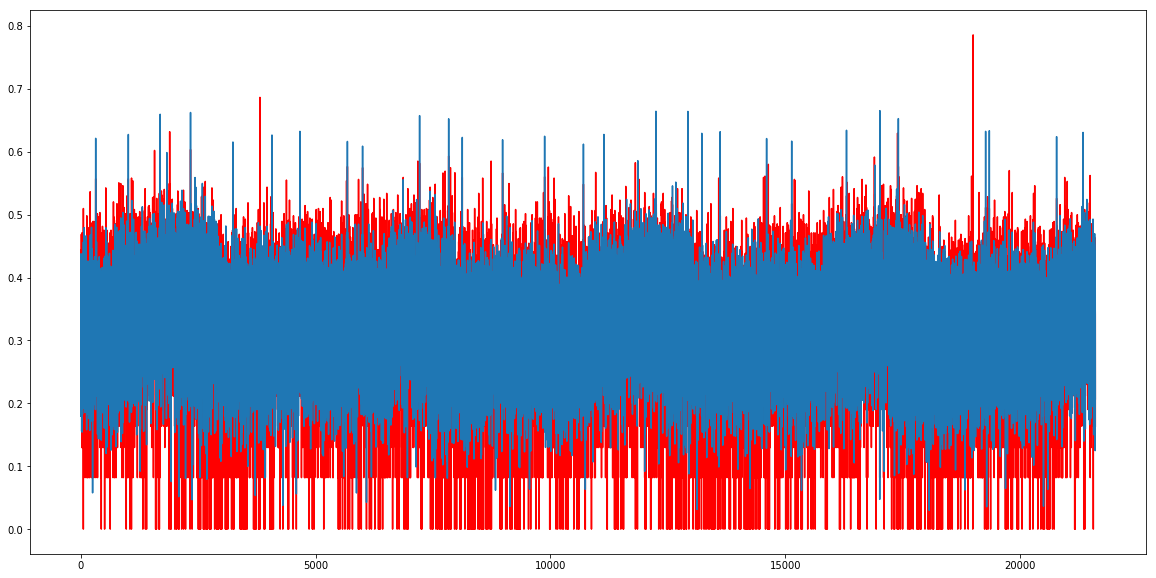

In [80]:
## plot valid result
pred_valid = model.predict(map_valid)
plt.figure(figsize=(20, 10))
plt.plot(y_valid[:].values, '-r')       #target
plt.plot(pred_valid[:].flatten())      #prediction

In [83]:
pred_valid_origin = log_max_inv(pred_valid, max_log_y)
y_valid_origin = log_max_inv(y_valid, max_log_y)

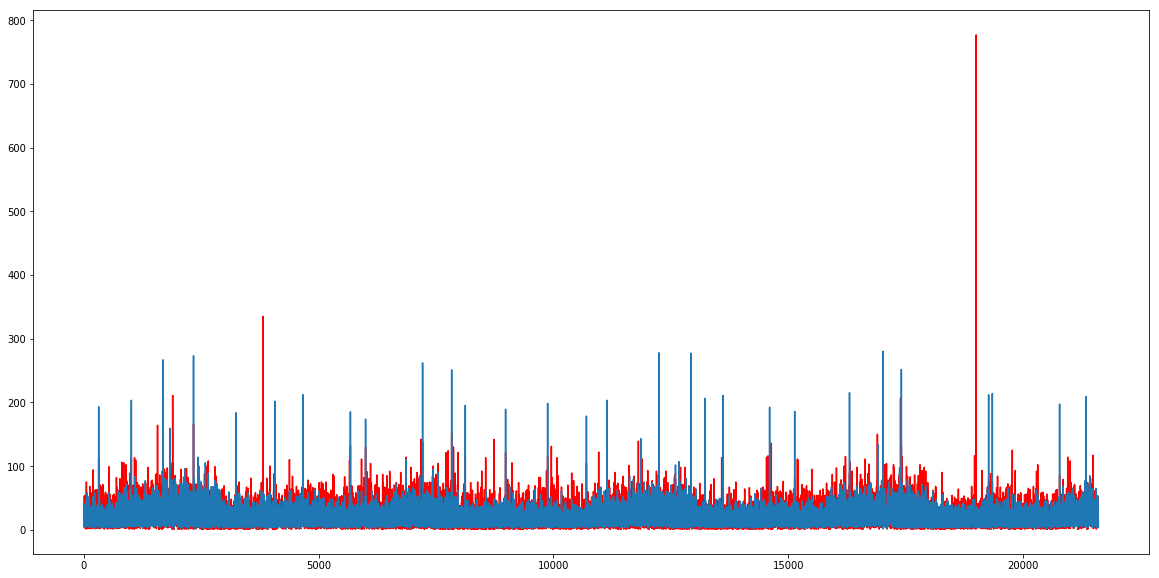

In [84]:
plt.figure(figsize=(20, 10))
plt.plot(y_valid_origin[:].values, '-r')       #target
plt.plot(pred_valid_origin[:].flatten())      #prediction

In [85]:
y_train.shape

(230507,)

In [87]:
import math
def rmsle(y_pred, targ):
   log_vars = np.log(targ + 1) - np.log(y_pred + 1)
   return math.sqrt(np.square(log_vars).mean())
rmsle(pred_valid_origin.flatten(), y_valid_origin.values.flatten())

0.5336185261214409

In [206]:
data_valid['y']=y_valid
data_valid['pred_y']=pred_valid

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [207]:
data_valid.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,air_latitude,air_longitude,hpg_genre_name,hpg_area_name,hpg_latitude,...,visit_date_month,visit_date_dayofmonth,holiday_flg,af_holiday_flg,be_holiday_flg,dur_time_holiday_flg,dur_holiday_flg,dur_prog_holiday_flg,y,pred_y
229733,air_e483f5b3c4f310e0,2017-03-23,10,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.581941,130.348436,UD,UD,0.0,...,3,23,UD,0.0,0.0,UD,0.0,0.0,0.271832,0.187095
229734,air_c225148c0fcc5c72,2017-03-23,31,Cafe/Sweets,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,UD,UD,0.0,...,3,23,UD,0.0,0.0,UD,0.0,0.0,0.405399,0.446546
229735,air_26f10355d9b4d82a,2017-03-23,30,Other,Ōsaka-fu Ōsaka-shi Kyōmachibori,34.687697,135.495413,UD,UD,0.0,...,3,23,UD,0.0,0.0,UD,0.0,0.0,0.401528,0.382837
229736,air_1d25ca6c76df48b4,2017-03-23,15,Izakaya,Ōsaka-fu Ōsaka-shi Ōgimachi,34.705362,135.510025,UD,UD,0.0,...,3,23,UD,0.0,0.0,UD,0.0,0.0,0.319699,0.424072
229737,air_9152d9926e5c4a3a,2017-03-23,40,Italian/French,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,UD,UD,0.0,...,3,23,UD,0.0,0.0,UD,0.0,0.0,0.435490,0.428546


In [208]:
data_valid.to_csv('./result/valid_result.csv')

## Submission

In [42]:
data_dir = r'./data'
test = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
trn_like_test = utils.tes2trn(test)
trn_like_test = trn_like_test.assign(visitors = 0)
trn_like_test.head()
stores, hol = genFeas(data)


In [45]:
test_data = data2fea(trn_like_test, stores, hol)
test_data.visit_date = test_data.visit_date.astype('str')
feas = genModelFeas(test_data)


/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [46]:
input_map = feas['x_map']
y = feas['y']

In [47]:
pred_test = model.predict(input_map)

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,6.245965
1,air_00a91d42b08b08d9_2017-04-24,22.311953
2,air_00a91d42b08b08d9_2017-04-25,13.283492
3,air_00a91d42b08b08d9_2017-04-26,8.135740
4,air_00a91d42b08b08d9_2017-04-27,45.770012


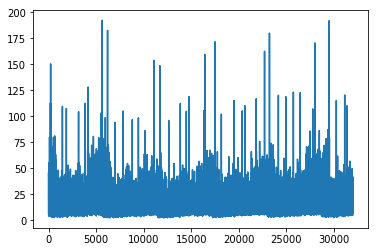

In [49]:
# pred_test = model.predict(input_map)
pred_test_orig = utils.log_max_inv(pred_test, max_log_y)
# pred_test_orig[pred_test_orig>1000] = pred_test_orig[pred_test_orig<1000].mean()
test.visitors = pred_test_orig
plt.plot(pred_test_orig)
# test.to_csv(‘result/submission.csv’, index=False)
test.head()

In [51]:
test.to_csv('result/submission.csv', index=False)